# Model prediction analysis

Before running this notebook, you *must* edit the code cell below to specify `output_model_name` for your model of interest. Batch scoring (and training) must already have been performed using this model, since this notebook will use the prediction results thus created.

In [2]:
from analysis_config_loader import ConfigFile
import os
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

output_model_name = '' # <-- fill in this value with your desired model's name!
config_filename = '../settings.cfg'

assert output_model_name != '', \
    'You must fill in the output_model_name field with the name of a model you trained ' + \
    'and applied to the operationalization dataset using batch_score_spark.py'
assert os.path.exists(config_filename), \
    'Could not find configuration file'.format(config_filename)
    
config = ConfigFile(config_filename, output_model_name)

## Test set analysis

### Overall and class-specific model performance metrics

In [3]:
n_correct_label = len(config.test_df.loc[config.test_df['label'] == config.test_df['pred_label']].index)
n_total = len(config.test_df.index)

print('Overall accuracy: {:.3f}'.format(n_correct_label / n_total))

Overall accuracy: 0.773


We can also calculate precision, recall, and accuracy for each label:

In [4]:
labels = np.sort(config.test_df['label'].unique()).tolist()

for label in labels:
    print('Metrics for {0} vs. not-{0} classification'.format(label))
    
    n_true_pos = len(config.test_df.loc[(config.test_df['label'] == label) & 
                                        (config.test_df['pred_label'] == label)].index)
    n_true_neg = len(config.test_df.loc[(config.test_df['label'] != label) & 
                                        (config.test_df['pred_label'] != label)].index)
    n_false_pos = len(config.test_df.loc[(config.test_df['label'] != label) & 
                                        (config.test_df['pred_label'] == label)].index)
    n_false_neg = len(config.test_df.loc[(config.test_df['label'] == label) & 
                                        (config.test_df['pred_label'] != label)].index)
    n_predicted_pos = n_true_pos + n_false_pos
    n_labeled_pos = n_true_neg + n_false_neg
    n_correct = n_true_pos + n_true_neg
    
    if n_labeled_pos == 0:
        print('- Recall:    Undefined (no images have this true label)')
    else:
        print('- Recall:    {:0.3f}'.format(n_true_pos / n_labeled_pos))
    if n_predicted_pos == 0:
        print('- Precision: Undefined (No images predicted to have this label)')
    else:
        print('- Precision: {:0.3f}'.format(n_true_pos / n_predicted_pos))
    print('- Accuracy:  {:0.3f}'.format(n_correct / n_total))

Metrics for Barren vs. not-Barren classification
- Recall:    0.127
- Precision: 0.935
- Accuracy:  0.922
Metrics for Cultivated vs. not-Cultivated classification
- Recall:    0.161
- Precision: 0.761
- Accuracy:  0.945
Metrics for Developed vs. not-Developed classification
- Recall:    0.202
- Precision: 0.955
- Accuracy:  0.977
Metrics for Forest vs. not-Forest classification
- Recall:    0.192
- Precision: 0.776
- Accuracy:  0.943
Metrics for Herbaceous vs. not-Herbaceous classification
- Recall:    0.091
- Precision: 0.721
- Accuracy:  0.901
Metrics for Shrub vs. not-Shrub classification
- Recall:    0.164
- Precision: 0.576
- Accuracy:  0.859


### Confusion matrix construction

We now construct a confusion matrix to check which types of classification errors are most common:

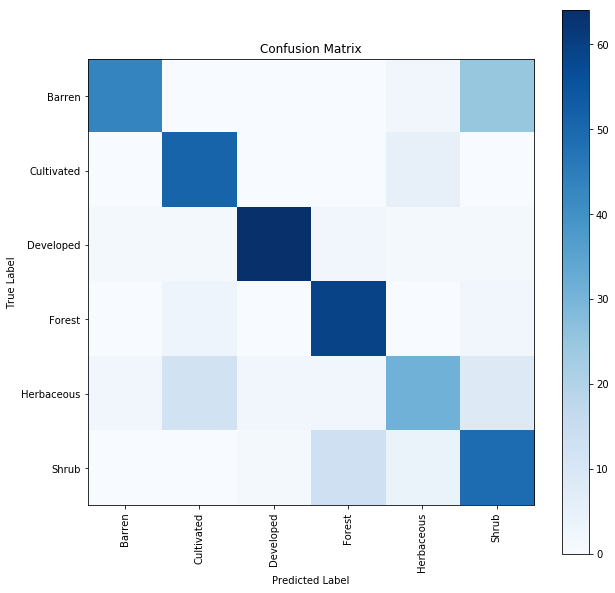

In [5]:
cm = confusion_matrix(config.test_df['label'], config.test_df['pred_label'], labels=labels)

plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

Off-diagonal elements of this matrix constitute errors. If you trained with the full dataset (the default setting of `sample_frac=1.0`), you should see that most elements fall along the diagonal, and off-diagonal elements are near-zero.

## Operationalization image set analysis

The true labels for the Middlesex County, MA images are unknown (and in many cases would be undefined, since an image may include land of multiple types), so we will not test their accuracy. However, we will use them to draw a predicted land use map of Middlesex County, MA:

During data loading, we merged the operationalization prediction dataframe with information on each tile's latitude and longitude boundaries:

In [6]:
config.o16n_df.head()

,name,pred_label,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
0,ortho_1-1_hn_s_ma017_2016_1_100240.png,Forest,42.679883,-71.791586,42.681898,-71.788856
1,ortho_1-1_hn_s_ma017_2016_1_100640.png,Forest,42.681898,-71.666017,42.683912,-71.663287
2,ortho_1-1_hn_s_ma017_2016_1_101026.png,Forest,42.683912,-71.578665,42.685927,-71.575935
3,ortho_1-1_hn_s_ma017_2016_1_101498.png,Forest,42.685927,-71.256552,42.687941,-71.253823
4,ortho_1-1_hn_s_ma017_2016_1_101864.png,Forest,42.687941,-71.223795,42.689956,-71.221065


In our county map, each image will be represented by a single pixel. The color of that pixel will be determined by the image's predicted label. We convert the latitude and longitude of each image's lower-righthand corner into an x and y index for a single pixel in the final image:

In [7]:
lat_values = np.sort(config.o16n_df['llcrnrlat'].unique()).tolist()
max_lat_idx = len(lat_values) - 1
lon_values = np.sort(config.o16n_df['llcrnrlon'].unique()).tolist()
config.o16n_df['x_idx'] = config.o16n_df['llcrnrlon'].apply(lambda x: lon_values.index(x))
config.o16n_df['y_idx'] = config.o16n_df['llcrnrlat'].apply(lambda x: lat_values.index(x))

Then we fill in the appropriate color for each pixel in an otherwise-black array, and display the result. (Note that the image's y-orientation will be inverted by the `pillow` package, so we fill in the rows from bottom to top.)

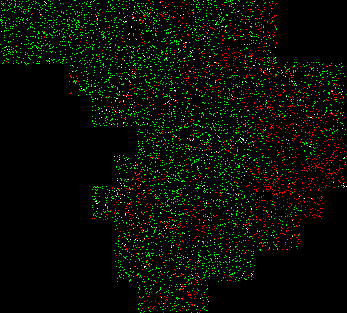

In [8]:
label_to_color_dict = {'Barren': np.array([0, 255, 0]),
                       'Cultivated': np.array([255, 255, 255]),
                       'Developed': np.array([255, 0, 0]),
                       'Forest': np.array([0, 255, 0]),
                       'Herbaceous': np.array([0, 255, 0]),
                       'Shrub': np.array([0, 255, 0])}

county_image = np.zeros((len(lat_values), len(lon_values), 3))
for row in config.o16n_df.itertuples():
    county_image[max_lat_idx - row.y_idx, row.x_idx, :] = label_to_color_dict[row.pred_label]
Image.fromarray(np.uint8(county_image))